# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

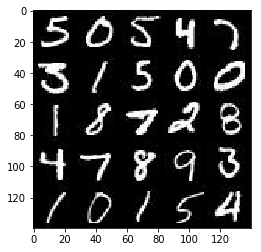

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images],
    28, 
    28, 
    'L'
)
pyplot.imshow(
    helper.images_square_grid(mnist_images, 'L'),
    cmap='gray'
)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

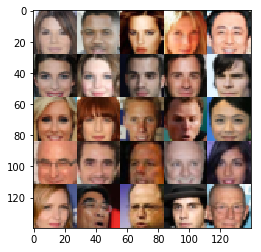

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(
        tf.float32,
        [None, image_width, image_height, image_channels]
    )
    z_input = tf.placeholder(
        tf.float32,
        [None, z_dim]
    )
    learning_rate = tf.placeholder(tf.float32)

    return (inputs, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, keep_probability=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):    
        # 28 x 28 x ?
        x1 = tf.layers.conv2d(
            images,
            64,
            5,
            strides = 2,
            padding = "same",
            kernel_initializer = tf.contrib.layers.xavier_initializer()
        )
        relu1 = tf.maximum(alpha * x1, x1)
        # print("layer 1 shape --> {}".format(relu1.shape)) # [14 x 14 x 64]
        
        x2 = tf.layers.conv2d(
            x1,
            128,
            5,
            strides = 2,
            padding = "same"
        )
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # print("layer 2 shape --> {}".format(relu2.shape)) # [7 x 7 x 128]
        
        x3 = tf.layers.conv2d(
            relu2,
            256,
            5,
            strides = 2,
            padding = "same"
        )
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # print("layer 3 shape --> {}".format(relu3.shape)) # [4 x 4 x 256]
        
        dropout = tf.nn.dropout(
            relu3,
            keep_prob=keep_probability
        )
        
        flat = tf.reshape(
            dropout,
            (-1, 4*4*256)
        )
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_probability=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        # Fully-Connected
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # [2 x 2 x 512]
        
        x2 = tf.layers.conv2d_transpose(
            x1,
            256,
            3,
            strides = 2,
            padding = "same"
        )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # print("Layer 1 = {}".format(x2.shape)) # [4 x 4 x 256]
        
        x3 = tf.layers.conv2d_transpose(
            x2,
            128,
            4,
            strides = 1,
            padding = "valid"
        )
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # print("Layer 2 = {}".format(x3.shape)) # [7 x 7 x 128]
        
        x4 = tf.layers.conv2d_transpose(
            x3,
            64,
            3,
            strides = 2,
            padding = "same"
        )
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # print("Layer 3 = {}".format(x4.shape)) # [14 x 14 x 64]
        
        
        dropout = tf.nn.dropout(x4, keep_prob=keep_probability)
        logits = tf.layers.conv2d_transpose(
            dropout,
            out_channel_dim,
            5,
            strides = 2,
            padding = "same"
        )
        output_tensor = tf.tanh(logits)
        # print("Output = {}".format(output_tensor.shape)) # [28 x 28 x 5]
        return output_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    model_generator = generator(
        input_z,
        out_channel_dim,
        is_train = True
    )
    model_real_discriminator, logits_real_discriminator = discriminator(
        input_real,
        reuse = False
    )
    model_fake_discriminator, logits_fake_discriminator = discriminator(
        model_generator,
        reuse = True
    )
    loss_real_discriminator = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = logits_real_discriminator,
            labels = tf.ones_like(model_real_discriminator) * 0.9
        )
    )
    loss_fake_discriminator = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = logits_fake_discriminator,
            labels = tf.zeros_like(model_fake_discriminator) * 0.9
        )
    )
    loss_generator = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = logits_fake_discriminator,
            labels = tf.ones_like(model_fake_discriminator)
        )
    )
    loss_discriminator = loss_real_discriminator + loss_fake_discriminator
    
    return (loss_discriminator, loss_generator)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    vars_train = tf.trainable_variables()
    vars_discriminator = [var for var in vars_train if var.name.startswith("discriminator")]
    vars_generator = [var for var in vars_train if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        train_operation_discriminator = tf.train.AdamOptimizer(
            learning_rate,
            beta1 = beta1
        ).minimize(
            d_loss,
            var_list = vars_discriminator
        )
        
        train_operation_generator = tf.train.AdamOptimizer(
            learning_rate,
            beta1 = beta1
        ).minimize(
            g_loss,
            var_list = vars_generator
        )
        
        return (train_operation_discriminator, train_operation_generator)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    counter = 0
    losses = []
    display_interval = 100
    print_interval = 10
    _, image_width, image_height, image_channels = data_shape

    input_, z_input_, learning_rate_ = model_inputs(
        image_width, 
        image_height, 
        image_channels, 
        z_dim
    )
    loss_discriminator, loss_generator = model_loss(
        input_, 
        z_input_, 
        image_channels
    )
    train_operation_discriminator, train_operation_generator = model_opt(
        loss_discriminator, 
        loss_generator, 
        learning_rate_, 
        beta1
    )

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                counter += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Thanks to rahul_ahuja and the forum post at
                # https://discussions.udacity.com/t/normalising-the-inputs/249561
                batch_images *= 2
                
                feed_dict = {
                    input_: batch_images,
                    z_input_: batch_z,
                    learning_rate_: learning_rate
                }
                
                sess.run(train_operation_discriminator, feed_dict=feed_dict)
                sess.run(train_operation_generator, feed_dict=feed_dict)
                sess.run(train_operation_generator, feed_dict=feed_dict)
                
                if counter % print_interval == 0:
                    train_loss_discriminator = loss_discriminator.eval({z_input_: batch_z, input_: batch_images})
                    train_loss_generator = loss_generator.eval({z_input_: batch_z})
                    print("Epoch {} of {}".format(epoch_i + 1, epoch_count),
                          "\tDiscriminator Loss = {:.3f}".format(train_loss_discriminator),
                          "\tGenerator Loss = {:.3f}".format(train_loss_generator),)
                    losses.append((train_loss_discriminator, train_loss_generator))
                if counter % display_interval == 0:
                    show_generator_output(sess, 16, z_input_, image_channels, data_image_mode)
                
                
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 of 2 	Discriminator Loss = 0.844 	Generator Loss = 1.152
Epoch 1 of 2 	Discriminator Loss = 1.810 	Generator Loss = 0.433
Epoch 1 of 2 	Discriminator Loss = 2.051 	Generator Loss = 0.485
Epoch 1 of 2 	Discriminator Loss = 1.595 	Generator Loss = 0.600
Epoch 1 of 2 	Discriminator Loss = 1.628 	Generator Loss = 0.722
Epoch 1 of 2 	Discriminator Loss = 1.120 	Generator Loss = 1.421
Epoch 1 of 2 	Discriminator Loss = 0.774 	Generator Loss = 1.681
Epoch 1 of 2 	Discriminator Loss = 0.816 	Generator Loss = 1.971
Epoch 1 of 2 	Discriminator Loss = 0.630 	Generator Loss = 3.759
Epoch 1 of 2 	Discriminator Loss = 0.896 	Generator Loss = 1.136


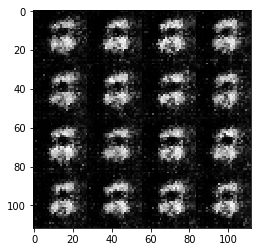

Epoch 1 of 2 	Discriminator Loss = 1.167 	Generator Loss = 0.856
Epoch 1 of 2 	Discriminator Loss = 0.726 	Generator Loss = 5.939
Epoch 1 of 2 	Discriminator Loss = 0.809 	Generator Loss = 1.773
Epoch 1 of 2 	Discriminator Loss = 0.631 	Generator Loss = 2.499
Epoch 1 of 2 	Discriminator Loss = 0.480 	Generator Loss = 2.571
Epoch 1 of 2 	Discriminator Loss = 0.499 	Generator Loss = 2.889
Epoch 1 of 2 	Discriminator Loss = 0.626 	Generator Loss = 1.887
Epoch 1 of 2 	Discriminator Loss = 0.575 	Generator Loss = 1.937
Epoch 1 of 2 	Discriminator Loss = 0.447 	Generator Loss = 3.106
Epoch 1 of 2 	Discriminator Loss = 0.522 	Generator Loss = 2.732


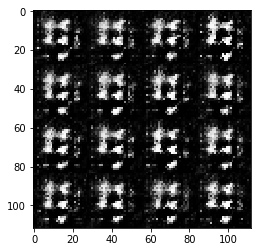

Epoch 1 of 2 	Discriminator Loss = 0.505 	Generator Loss = 3.285
Epoch 1 of 2 	Discriminator Loss = 0.525 	Generator Loss = 2.754
Epoch 1 of 2 	Discriminator Loss = 0.800 	Generator Loss = 1.525
Epoch 1 of 2 	Discriminator Loss = 0.802 	Generator Loss = 2.858
Epoch 1 of 2 	Discriminator Loss = 0.609 	Generator Loss = 3.523
Epoch 1 of 2 	Discriminator Loss = 0.526 	Generator Loss = 2.892
Epoch 1 of 2 	Discriminator Loss = 0.671 	Generator Loss = 1.776
Epoch 1 of 2 	Discriminator Loss = 0.905 	Generator Loss = 1.413
Epoch 1 of 2 	Discriminator Loss = 0.695 	Generator Loss = 2.463
Epoch 1 of 2 	Discriminator Loss = 0.585 	Generator Loss = 3.003


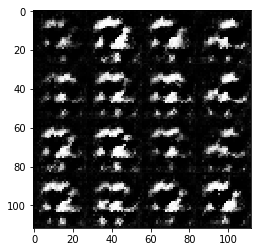

Epoch 1 of 2 	Discriminator Loss = 0.793 	Generator Loss = 1.568
Epoch 1 of 2 	Discriminator Loss = 0.690 	Generator Loss = 2.516
Epoch 1 of 2 	Discriminator Loss = 0.929 	Generator Loss = 1.268
Epoch 1 of 2 	Discriminator Loss = 0.733 	Generator Loss = 2.094
Epoch 1 of 2 	Discriminator Loss = 1.079 	Generator Loss = 1.302
Epoch 1 of 2 	Discriminator Loss = 1.018 	Generator Loss = 1.496
Epoch 1 of 2 	Discriminator Loss = 1.257 	Generator Loss = 0.928
Epoch 1 of 2 	Discriminator Loss = 0.972 	Generator Loss = 1.542
Epoch 1 of 2 	Discriminator Loss = 0.913 	Generator Loss = 2.268
Epoch 1 of 2 	Discriminator Loss = 0.930 	Generator Loss = 1.383


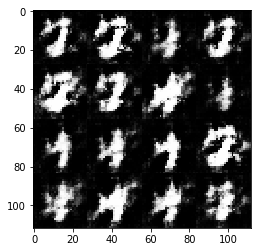

Epoch 1 of 2 	Discriminator Loss = 0.733 	Generator Loss = 2.295
Epoch 1 of 2 	Discriminator Loss = 1.007 	Generator Loss = 1.280
Epoch 1 of 2 	Discriminator Loss = 0.908 	Generator Loss = 1.748
Epoch 1 of 2 	Discriminator Loss = 1.083 	Generator Loss = 1.673
Epoch 1 of 2 	Discriminator Loss = 1.014 	Generator Loss = 1.304
Epoch 1 of 2 	Discriminator Loss = 1.100 	Generator Loss = 1.128
Epoch 1 of 2 	Discriminator Loss = 1.010 	Generator Loss = 1.134
Epoch 1 of 2 	Discriminator Loss = 1.282 	Generator Loss = 1.267
Epoch 1 of 2 	Discriminator Loss = 1.061 	Generator Loss = 1.387
Epoch 1 of 2 	Discriminator Loss = 1.206 	Generator Loss = 0.966


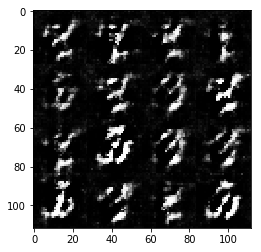

Epoch 1 of 2 	Discriminator Loss = 1.099 	Generator Loss = 1.496
Epoch 1 of 2 	Discriminator Loss = 0.942 	Generator Loss = 1.500
Epoch 1 of 2 	Discriminator Loss = 1.217 	Generator Loss = 1.241
Epoch 1 of 2 	Discriminator Loss = 0.882 	Generator Loss = 1.605
Epoch 1 of 2 	Discriminator Loss = 1.177 	Generator Loss = 1.055
Epoch 1 of 2 	Discriminator Loss = 1.083 	Generator Loss = 1.054
Epoch 1 of 2 	Discriminator Loss = 0.953 	Generator Loss = 1.483
Epoch 1 of 2 	Discriminator Loss = 0.936 	Generator Loss = 1.663
Epoch 1 of 2 	Discriminator Loss = 0.853 	Generator Loss = 1.623
Epoch 1 of 2 	Discriminator Loss = 1.125 	Generator Loss = 1.074


Epoch 1 of 2 	Discriminator Loss = 0.983 	Generator Loss = 1.427
Epoch 1 of 2 	Discriminator Loss = 1.138 	Generator Loss = 1.215
Epoch 1 of 2 	Discriminator Loss = 1.087 	Generator Loss = 1.243
Epoch 1 of 2 	Discriminator Loss = 0.861 	Generator Loss = 1.584
Epoch 1 of 2 	Discriminator Loss = 1.110 	Generator Loss = 1.169
Epoch 1 of 2 	Discriminator Loss = 1.195 	Generator Loss = 0.920
Epoch 1 of 2 	Discriminator Loss = 0.903 	Generator Loss = 1.591
Epoch 1 of 2 	Discriminator Loss = 0.985 	Generator Loss = 1.349
Epoch 1 of 2 	Discriminator Loss = 1.000 	Generator Loss = 1.240
Epoch 1 of 2 	Discriminator Loss = 1.182 	Generator Loss = 1.357


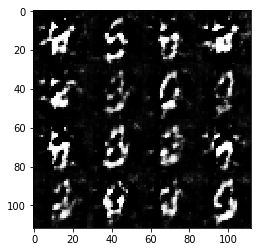

Epoch 1 of 2 	Discriminator Loss = 1.076 	Generator Loss = 1.457
Epoch 1 of 2 	Discriminator Loss = 0.863 	Generator Loss = 1.821
Epoch 1 of 2 	Discriminator Loss = 1.005 	Generator Loss = 1.631
Epoch 1 of 2 	Discriminator Loss = 0.868 	Generator Loss = 1.505
Epoch 1 of 2 	Discriminator Loss = 1.026 	Generator Loss = 1.173
Epoch 1 of 2 	Discriminator Loss = 0.961 	Generator Loss = 1.519
Epoch 1 of 2 	Discriminator Loss = 1.160 	Generator Loss = 1.239
Epoch 1 of 2 	Discriminator Loss = 0.748 	Generator Loss = 1.493
Epoch 1 of 2 	Discriminator Loss = 0.807 	Generator Loss = 1.653
Epoch 1 of 2 	Discriminator Loss = 1.093 	Generator Loss = 1.033


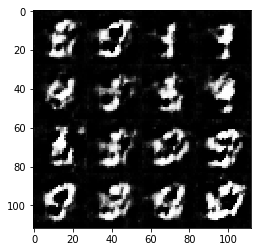

Epoch 1 of 2 	Discriminator Loss = 0.957 	Generator Loss = 1.406
Epoch 1 of 2 	Discriminator Loss = 1.250 	Generator Loss = 0.815
Epoch 1 of 2 	Discriminator Loss = 1.331 	Generator Loss = 0.980
Epoch 1 of 2 	Discriminator Loss = 1.061 	Generator Loss = 0.977
Epoch 1 of 2 	Discriminator Loss = 1.136 	Generator Loss = 1.513
Epoch 1 of 2 	Discriminator Loss = 1.092 	Generator Loss = 1.211
Epoch 1 of 2 	Discriminator Loss = 1.139 	Generator Loss = 1.804
Epoch 1 of 2 	Discriminator Loss = 0.928 	Generator Loss = 1.482
Epoch 1 of 2 	Discriminator Loss = 1.008 	Generator Loss = 1.463
Epoch 1 of 2 	Discriminator Loss = 0.949 	Generator Loss = 1.903


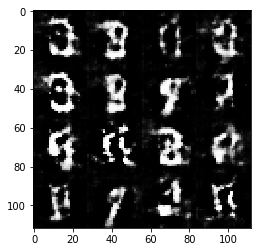

Epoch 1 of 2 	Discriminator Loss = 1.074 	Generator Loss = 1.171
Epoch 1 of 2 	Discriminator Loss = 1.073 	Generator Loss = 1.171
Epoch 1 of 2 	Discriminator Loss = 1.017 	Generator Loss = 1.052
Epoch 2 of 2 	Discriminator Loss = 0.916 	Generator Loss = 1.304
Epoch 2 of 2 	Discriminator Loss = 1.202 	Generator Loss = 1.041
Epoch 2 of 2 	Discriminator Loss = 1.134 	Generator Loss = 1.284
Epoch 2 of 2 	Discriminator Loss = 1.247 	Generator Loss = 1.009
Epoch 2 of 2 	Discriminator Loss = 1.118 	Generator Loss = 1.151
Epoch 2 of 2 	Discriminator Loss = 1.158 	Generator Loss = 1.044
Epoch 2 of 2 	Discriminator Loss = 1.049 	Generator Loss = 1.002


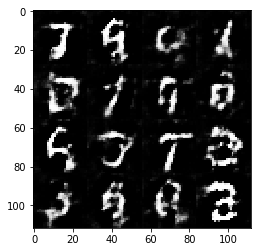

Epoch 2 of 2 	Discriminator Loss = 0.952 	Generator Loss = 1.409
Epoch 2 of 2 	Discriminator Loss = 1.161 	Generator Loss = 1.178
Epoch 2 of 2 	Discriminator Loss = 1.238 	Generator Loss = 0.730
Epoch 2 of 2 	Discriminator Loss = 1.274 	Generator Loss = 1.352
Epoch 2 of 2 	Discriminator Loss = 1.273 	Generator Loss = 0.928
Epoch 2 of 2 	Discriminator Loss = 1.226 	Generator Loss = 0.734
Epoch 2 of 2 	Discriminator Loss = 1.102 	Generator Loss = 0.884
Epoch 2 of 2 	Discriminator Loss = 1.199 	Generator Loss = 1.453
Epoch 2 of 2 	Discriminator Loss = 1.131 	Generator Loss = 1.100
Epoch 2 of 2 	Discriminator Loss = 1.102 	Generator Loss = 1.128


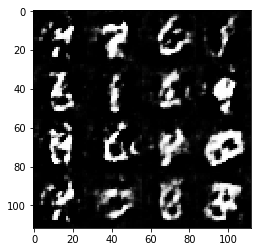

Epoch 2 of 2 	Discriminator Loss = 1.201 	Generator Loss = 1.116
Epoch 2 of 2 	Discriminator Loss = 1.093 	Generator Loss = 1.120
Epoch 2 of 2 	Discriminator Loss = 1.239 	Generator Loss = 0.992
Epoch 2 of 2 	Discriminator Loss = 1.217 	Generator Loss = 1.220
Epoch 2 of 2 	Discriminator Loss = 1.194 	Generator Loss = 0.825
Epoch 2 of 2 	Discriminator Loss = 1.222 	Generator Loss = 0.896
Epoch 2 of 2 	Discriminator Loss = 1.232 	Generator Loss = 1.402
Epoch 2 of 2 	Discriminator Loss = 1.115 	Generator Loss = 1.173
Epoch 2 of 2 	Discriminator Loss = 1.084 	Generator Loss = 1.158
Epoch 2 of 2 	Discriminator Loss = 1.132 	Generator Loss = 1.025


Epoch 2 of 2 	Discriminator Loss = 1.197 	Generator Loss = 1.057
Epoch 2 of 2 	Discriminator Loss = 1.230 	Generator Loss = 0.902
Epoch 2 of 2 	Discriminator Loss = 0.991 	Generator Loss = 1.260
Epoch 2 of 2 	Discriminator Loss = 1.145 	Generator Loss = 0.952
Epoch 2 of 2 	Discriminator Loss = 1.347 	Generator Loss = 0.670
Epoch 2 of 2 	Discriminator Loss = 1.190 	Generator Loss = 0.893
Epoch 2 of 2 	Discriminator Loss = 1.294 	Generator Loss = 0.781
Epoch 2 of 2 	Discriminator Loss = 1.169 	Generator Loss = 0.940
Epoch 2 of 2 	Discriminator Loss = 1.130 	Generator Loss = 1.280
Epoch 2 of 2 	Discriminator Loss = 1.173 	Generator Loss = 0.998


Epoch 2 of 2 	Discriminator Loss = 1.167 	Generator Loss = 1.088
Epoch 2 of 2 	Discriminator Loss = 1.152 	Generator Loss = 1.160
Epoch 2 of 2 	Discriminator Loss = 1.224 	Generator Loss = 0.940
Epoch 2 of 2 	Discriminator Loss = 1.193 	Generator Loss = 1.478
Epoch 2 of 2 	Discriminator Loss = 1.256 	Generator Loss = 0.937
Epoch 2 of 2 	Discriminator Loss = 1.117 	Generator Loss = 1.340
Epoch 2 of 2 	Discriminator Loss = 1.055 	Generator Loss = 1.378
Epoch 2 of 2 	Discriminator Loss = 1.213 	Generator Loss = 0.903
Epoch 2 of 2 	Discriminator Loss = 1.205 	Generator Loss = 0.984
Epoch 2 of 2 	Discriminator Loss = 1.169 	Generator Loss = 0.917


Epoch 2 of 2 	Discriminator Loss = 1.231 	Generator Loss = 0.938
Epoch 2 of 2 	Discriminator Loss = 1.223 	Generator Loss = 1.232
Epoch 2 of 2 	Discriminator Loss = 1.239 	Generator Loss = 1.347
Epoch 2 of 2 	Discriminator Loss = 1.259 	Generator Loss = 0.895
Epoch 2 of 2 	Discriminator Loss = 1.140 	Generator Loss = 1.270
Epoch 2 of 2 	Discriminator Loss = 1.073 	Generator Loss = 1.350
Epoch 2 of 2 	Discriminator Loss = 1.272 	Generator Loss = 1.635
Epoch 2 of 2 	Discriminator Loss = 1.134 	Generator Loss = 1.123
Epoch 2 of 2 	Discriminator Loss = 1.257 	Generator Loss = 0.971
Epoch 2 of 2 	Discriminator Loss = 1.323 	Generator Loss = 0.727


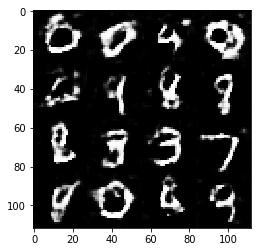

Epoch 2 of 2 	Discriminator Loss = 1.226 	Generator Loss = 1.179
Epoch 2 of 2 	Discriminator Loss = 1.345 	Generator Loss = 0.606
Epoch 2 of 2 	Discriminator Loss = 1.018 	Generator Loss = 1.174
Epoch 2 of 2 	Discriminator Loss = 1.312 	Generator Loss = 0.655
Epoch 2 of 2 	Discriminator Loss = 1.116 	Generator Loss = 1.090
Epoch 2 of 2 	Discriminator Loss = 1.134 	Generator Loss = 1.018
Epoch 2 of 2 	Discriminator Loss = 1.150 	Generator Loss = 1.279
Epoch 2 of 2 	Discriminator Loss = 1.249 	Generator Loss = 0.970
Epoch 2 of 2 	Discriminator Loss = 1.243 	Generator Loss = 0.789
Epoch 2 of 2 	Discriminator Loss = 1.256 	Generator Loss = 1.187


Epoch 2 of 2 	Discriminator Loss = 1.139 	Generator Loss = 1.252
Epoch 2 of 2 	Discriminator Loss = 1.372 	Generator Loss = 1.031
Epoch 2 of 2 	Discriminator Loss = 1.190 	Generator Loss = 0.861
Epoch 2 of 2 	Discriminator Loss = 1.210 	Generator Loss = 1.547
Epoch 2 of 2 	Discriminator Loss = 1.191 	Generator Loss = 1.606
Epoch 2 of 2 	Discriminator Loss = 1.196 	Generator Loss = 0.823
Epoch 2 of 2 	Discriminator Loss = 1.156 	Generator Loss = 0.903
Epoch 2 of 2 	Discriminator Loss = 1.220 	Generator Loss = 1.404
Epoch 2 of 2 	Discriminator Loss = 1.268 	Generator Loss = 0.695
Epoch 2 of 2 	Discriminator Loss = 1.158 	Generator Loss = 1.305


Epoch 2 of 2 	Discriminator Loss = 1.257 	Generator Loss = 0.799
Epoch 2 of 2 	Discriminator Loss = 1.212 	Generator Loss = 0.881
Epoch 2 of 2 	Discriminator Loss = 1.249 	Generator Loss = 0.964
Epoch 2 of 2 	Discriminator Loss = 1.180 	Generator Loss = 0.960
Epoch 2 of 2 	Discriminator Loss = 1.283 	Generator Loss = 1.209
Epoch 2 of 2 	Discriminator Loss = 1.225 	Generator Loss = 1.407
Epoch 2 of 2 	Discriminator Loss = 1.292 	Generator Loss = 0.731
Epoch 2 of 2 	Discriminator Loss = 1.340 	Generator Loss = 0.726
Epoch 2 of 2 	Discriminator Loss = 1.292 	Generator Loss = 1.038
Epoch 2 of 2 	Discriminator Loss = 1.328 	Generator Loss = 1.658


Epoch 2 of 2 	Discriminator Loss = 1.140 	Generator Loss = 0.869
Epoch 2 of 2 	Discriminator Loss = 1.240 	Generator Loss = 0.898
Epoch 2 of 2 	Discriminator Loss = 1.220 	Generator Loss = 1.187
Epoch 2 of 2 	Discriminator Loss = 1.106 	Generator Loss = 1.197
Epoch 2 of 2 	Discriminator Loss = 1.239 	Generator Loss = 0.989
Epoch 2 of 2 	Discriminator Loss = 1.151 	Generator Loss = 1.205
Epoch 2 of 2 	Discriminator Loss = 1.299 	Generator Loss = 0.752


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 of 1 	Discriminator Loss = 0.887 	Generator Loss = 1.782
Epoch 1 of 1 	Discriminator Loss = 1.281 	Generator Loss = 0.963
Epoch 1 of 1 	Discriminator Loss = 0.643 	Generator Loss = 2.591
Epoch 1 of 1 	Discriminator Loss = 0.654 	Generator Loss = 6.089
Epoch 1 of 1 	Discriminator Loss = 0.968 	Generator Loss = 1.147
Epoch 1 of 1 	Discriminator Loss = 1.264 	Generator Loss = 8.086
Epoch 1 of 1 	Discriminator Loss = 0.610 	Generator Loss = 2.775
Epoch 1 of 1 	Discriminator Loss = 0.462 	Generator Loss = 4.276
Epoch 1 of 1 	Discriminator Loss = 0.502 	Generator Loss = 3.329
Epoch 1 of 1 	Discriminator Loss = 0.465 	Generator Loss = 2.989


Epoch 1 of 1 	Discriminator Loss = 0.540 	Generator Loss = 2.090
Epoch 1 of 1 	Discriminator Loss = 0.485 	Generator Loss = 3.496
Epoch 1 of 1 	Discriminator Loss = 0.493 	Generator Loss = 3.101
Epoch 1 of 1 	Discriminator Loss = 0.424 	Generator Loss = 3.618
Epoch 1 of 1 	Discriminator Loss = 0.416 	Generator Loss = 3.059
Epoch 1 of 1 	Discriminator Loss = 0.427 	Generator Loss = 3.482
Epoch 1 of 1 	Discriminator Loss = 0.542 	Generator Loss = 1.987
Epoch 1 of 1 	Discriminator Loss = 0.591 	Generator Loss = 8.161
Epoch 1 of 1 	Discriminator Loss = 0.515 	Generator Loss = 3.300
Epoch 1 of 1 	Discriminator Loss = 0.917 	Generator Loss = 3.063


Epoch 1 of 1 	Discriminator Loss = 0.808 	Generator Loss = 3.083
Epoch 1 of 1 	Discriminator Loss = 0.827 	Generator Loss = 1.171
Epoch 1 of 1 	Discriminator Loss = 0.896 	Generator Loss = 1.314
Epoch 1 of 1 	Discriminator Loss = 0.717 	Generator Loss = 1.349
Epoch 1 of 1 	Discriminator Loss = 0.781 	Generator Loss = 1.272
Epoch 1 of 1 	Discriminator Loss = 1.167 	Generator Loss = 0.862
Epoch 1 of 1 	Discriminator Loss = 0.880 	Generator Loss = 1.865
Epoch 1 of 1 	Discriminator Loss = 0.836 	Generator Loss = 1.535
Epoch 1 of 1 	Discriminator Loss = 1.233 	Generator Loss = 0.627
Epoch 1 of 1 	Discriminator Loss = 0.840 	Generator Loss = 1.121


Epoch 1 of 1 	Discriminator Loss = 0.865 	Generator Loss = 1.527
Epoch 1 of 1 	Discriminator Loss = 1.177 	Generator Loss = 0.695
Epoch 1 of 1 	Discriminator Loss = 0.705 	Generator Loss = 1.962
Epoch 1 of 1 	Discriminator Loss = 0.989 	Generator Loss = 2.039
Epoch 1 of 1 	Discriminator Loss = 1.278 	Generator Loss = 3.687
Epoch 1 of 1 	Discriminator Loss = 1.159 	Generator Loss = 0.924
Epoch 1 of 1 	Discriminator Loss = 1.343 	Generator Loss = 0.908
Epoch 1 of 1 	Discriminator Loss = 1.227 	Generator Loss = 1.688
Epoch 1 of 1 	Discriminator Loss = 1.305 	Generator Loss = 0.931
Epoch 1 of 1 	Discriminator Loss = 1.041 	Generator Loss = 1.289


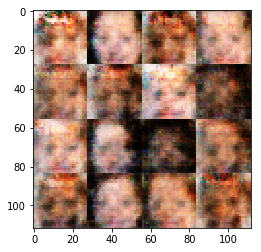

Epoch 1 of 1 	Discriminator Loss = 1.459 	Generator Loss = 0.787
Epoch 1 of 1 	Discriminator Loss = 1.485 	Generator Loss = 1.099
Epoch 1 of 1 	Discriminator Loss = 0.945 	Generator Loss = 1.154
Epoch 1 of 1 	Discriminator Loss = 1.034 	Generator Loss = 1.173
Epoch 1 of 1 	Discriminator Loss = 1.421 	Generator Loss = 0.855
Epoch 1 of 1 	Discriminator Loss = 1.127 	Generator Loss = 1.086
Epoch 1 of 1 	Discriminator Loss = 0.972 	Generator Loss = 1.100
Epoch 1 of 1 	Discriminator Loss = 1.304 	Generator Loss = 1.596
Epoch 1 of 1 	Discriminator Loss = 1.486 	Generator Loss = 0.726
Epoch 1 of 1 	Discriminator Loss = 1.573 	Generator Loss = 0.653


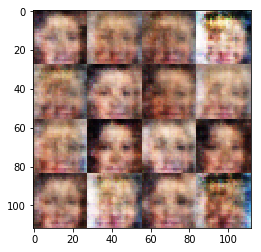

Epoch 1 of 1 	Discriminator Loss = 1.086 	Generator Loss = 1.374
Epoch 1 of 1 	Discriminator Loss = 1.249 	Generator Loss = 1.120
Epoch 1 of 1 	Discriminator Loss = 1.219 	Generator Loss = 0.944
Epoch 1 of 1 	Discriminator Loss = 1.223 	Generator Loss = 0.927
Epoch 1 of 1 	Discriminator Loss = 1.189 	Generator Loss = 1.118
Epoch 1 of 1 	Discriminator Loss = 1.499 	Generator Loss = 0.670
Epoch 1 of 1 	Discriminator Loss = 1.197 	Generator Loss = 1.006
Epoch 1 of 1 	Discriminator Loss = 1.349 	Generator Loss = 1.113
Epoch 1 of 1 	Discriminator Loss = 1.480 	Generator Loss = 0.953
Epoch 1 of 1 	Discriminator Loss = 1.649 	Generator Loss = 0.931


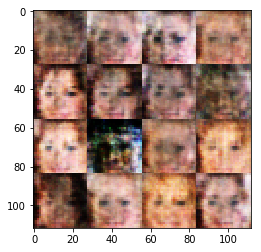

Epoch 1 of 1 	Discriminator Loss = 1.239 	Generator Loss = 0.968
Epoch 1 of 1 	Discriminator Loss = 1.232 	Generator Loss = 1.132
Epoch 1 of 1 	Discriminator Loss = 1.261 	Generator Loss = 1.146
Epoch 1 of 1 	Discriminator Loss = 1.108 	Generator Loss = 0.960
Epoch 1 of 1 	Discriminator Loss = 1.417 	Generator Loss = 0.894
Epoch 1 of 1 	Discriminator Loss = 1.241 	Generator Loss = 0.827
Epoch 1 of 1 	Discriminator Loss = 1.217 	Generator Loss = 1.063
Epoch 1 of 1 	Discriminator Loss = 1.109 	Generator Loss = 1.318
Epoch 1 of 1 	Discriminator Loss = 1.318 	Generator Loss = 1.029
Epoch 1 of 1 	Discriminator Loss = 1.644 	Generator Loss = 0.881


Epoch 1 of 1 	Discriminator Loss = 1.431 	Generator Loss = 0.793
Epoch 1 of 1 	Discriminator Loss = 1.290 	Generator Loss = 0.989
Epoch 1 of 1 	Discriminator Loss = 1.327 	Generator Loss = 1.205
Epoch 1 of 1 	Discriminator Loss = 1.369 	Generator Loss = 0.792
Epoch 1 of 1 	Discriminator Loss = 1.185 	Generator Loss = 1.324
Epoch 1 of 1 	Discriminator Loss = 1.315 	Generator Loss = 1.058
Epoch 1 of 1 	Discriminator Loss = 1.333 	Generator Loss = 0.950
Epoch 1 of 1 	Discriminator Loss = 1.441 	Generator Loss = 0.790
Epoch 1 of 1 	Discriminator Loss = 1.280 	Generator Loss = 1.041
Epoch 1 of 1 	Discriminator Loss = 1.648 	Generator Loss = 0.828


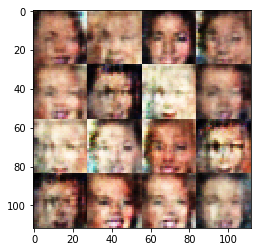

Epoch 1 of 1 	Discriminator Loss = 1.449 	Generator Loss = 0.798
Epoch 1 of 1 	Discriminator Loss = 1.441 	Generator Loss = 0.855
Epoch 1 of 1 	Discriminator Loss = 1.432 	Generator Loss = 0.999
Epoch 1 of 1 	Discriminator Loss = 1.307 	Generator Loss = 0.914
Epoch 1 of 1 	Discriminator Loss = 1.459 	Generator Loss = 0.854
Epoch 1 of 1 	Discriminator Loss = 1.281 	Generator Loss = 1.170
Epoch 1 of 1 	Discriminator Loss = 1.240 	Generator Loss = 0.941
Epoch 1 of 1 	Discriminator Loss = 1.361 	Generator Loss = 0.962
Epoch 1 of 1 	Discriminator Loss = 1.329 	Generator Loss = 1.160
Epoch 1 of 1 	Discriminator Loss = 1.396 	Generator Loss = 0.988


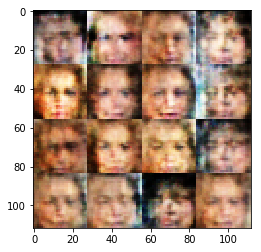

Epoch 1 of 1 	Discriminator Loss = 1.082 	Generator Loss = 1.051
Epoch 1 of 1 	Discriminator Loss = 1.238 	Generator Loss = 0.914
Epoch 1 of 1 	Discriminator Loss = 1.291 	Generator Loss = 1.118
Epoch 1 of 1 	Discriminator Loss = 1.176 	Generator Loss = 0.936
Epoch 1 of 1 	Discriminator Loss = 1.195 	Generator Loss = 1.275
Epoch 1 of 1 	Discriminator Loss = 1.358 	Generator Loss = 0.817
Epoch 1 of 1 	Discriminator Loss = 1.283 	Generator Loss = 0.998
Epoch 1 of 1 	Discriminator Loss = 1.332 	Generator Loss = 0.926
Epoch 1 of 1 	Discriminator Loss = 1.381 	Generator Loss = 1.086
Epoch 1 of 1 	Discriminator Loss = 1.343 	Generator Loss = 0.919


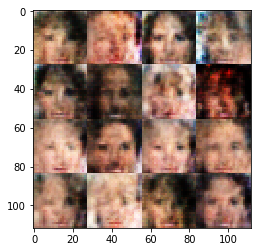

Epoch 1 of 1 	Discriminator Loss = 1.285 	Generator Loss = 0.839
Epoch 1 of 1 	Discriminator Loss = 1.234 	Generator Loss = 1.054
Epoch 1 of 1 	Discriminator Loss = 1.371 	Generator Loss = 0.971
Epoch 1 of 1 	Discriminator Loss = 1.297 	Generator Loss = 0.935
Epoch 1 of 1 	Discriminator Loss = 1.133 	Generator Loss = 0.976
Epoch 1 of 1 	Discriminator Loss = 1.311 	Generator Loss = 0.832
Epoch 1 of 1 	Discriminator Loss = 1.244 	Generator Loss = 1.131
Epoch 1 of 1 	Discriminator Loss = 1.257 	Generator Loss = 0.960
Epoch 1 of 1 	Discriminator Loss = 1.263 	Generator Loss = 1.101
Epoch 1 of 1 	Discriminator Loss = 1.165 	Generator Loss = 1.150


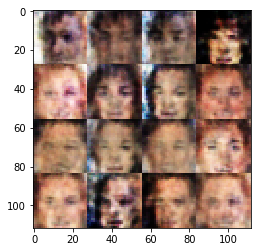

Epoch 1 of 1 	Discriminator Loss = 1.229 	Generator Loss = 0.936
Epoch 1 of 1 	Discriminator Loss = 1.313 	Generator Loss = 1.056
Epoch 1 of 1 	Discriminator Loss = 1.067 	Generator Loss = 1.298
Epoch 1 of 1 	Discriminator Loss = 1.223 	Generator Loss = 1.097
Epoch 1 of 1 	Discriminator Loss = 1.303 	Generator Loss = 1.059
Epoch 1 of 1 	Discriminator Loss = 1.299 	Generator Loss = 1.016
Epoch 1 of 1 	Discriminator Loss = 1.330 	Generator Loss = 1.080
Epoch 1 of 1 	Discriminator Loss = 1.297 	Generator Loss = 0.981
Epoch 1 of 1 	Discriminator Loss = 1.297 	Generator Loss = 0.887
Epoch 1 of 1 	Discriminator Loss = 1.196 	Generator Loss = 1.130


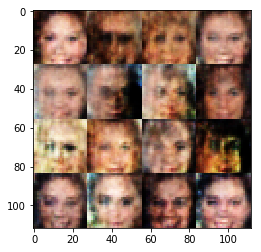

Epoch 1 of 1 	Discriminator Loss = 1.527 	Generator Loss = 0.770
Epoch 1 of 1 	Discriminator Loss = 1.444 	Generator Loss = 0.701
Epoch 1 of 1 	Discriminator Loss = 1.278 	Generator Loss = 0.871
Epoch 1 of 1 	Discriminator Loss = 1.270 	Generator Loss = 0.912
Epoch 1 of 1 	Discriminator Loss = 1.301 	Generator Loss = 0.865
Epoch 1 of 1 	Discriminator Loss = 1.197 	Generator Loss = 1.025
Epoch 1 of 1 	Discriminator Loss = 1.352 	Generator Loss = 0.958
Epoch 1 of 1 	Discriminator Loss = 1.187 	Generator Loss = 0.948
Epoch 1 of 1 	Discriminator Loss = 1.322 	Generator Loss = 0.868
Epoch 1 of 1 	Discriminator Loss = 1.282 	Generator Loss = 1.029


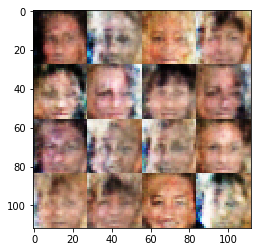

Epoch 1 of 1 	Discriminator Loss = 1.290 	Generator Loss = 0.938
Epoch 1 of 1 	Discriminator Loss = 1.211 	Generator Loss = 1.004
Epoch 1 of 1 	Discriminator Loss = 1.201 	Generator Loss = 0.951
Epoch 1 of 1 	Discriminator Loss = 1.168 	Generator Loss = 0.861
Epoch 1 of 1 	Discriminator Loss = 1.201 	Generator Loss = 1.014
Epoch 1 of 1 	Discriminator Loss = 1.299 	Generator Loss = 1.085
Epoch 1 of 1 	Discriminator Loss = 1.210 	Generator Loss = 0.949
Epoch 1 of 1 	Discriminator Loss = 1.266 	Generator Loss = 1.097
Epoch 1 of 1 	Discriminator Loss = 1.341 	Generator Loss = 0.860
Epoch 1 of 1 	Discriminator Loss = 1.256 	Generator Loss = 1.131


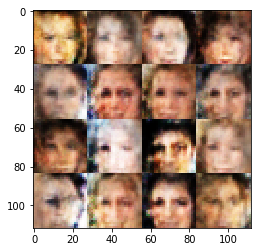

Epoch 1 of 1 	Discriminator Loss = 1.311 	Generator Loss = 0.963
Epoch 1 of 1 	Discriminator Loss = 1.206 	Generator Loss = 0.847
Epoch 1 of 1 	Discriminator Loss = 1.363 	Generator Loss = 0.859
Epoch 1 of 1 	Discriminator Loss = 1.301 	Generator Loss = 0.916
Epoch 1 of 1 	Discriminator Loss = 1.351 	Generator Loss = 0.949
Epoch 1 of 1 	Discriminator Loss = 1.325 	Generator Loss = 0.916
Epoch 1 of 1 	Discriminator Loss = 1.280 	Generator Loss = 0.810
Epoch 1 of 1 	Discriminator Loss = 1.268 	Generator Loss = 0.950
Epoch 1 of 1 	Discriminator Loss = 1.368 	Generator Loss = 0.766
Epoch 1 of 1 	Discriminator Loss = 1.388 	Generator Loss = 0.919


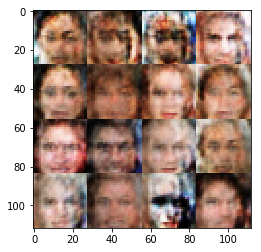

Epoch 1 of 1 	Discriminator Loss = 1.447 	Generator Loss = 0.857
Epoch 1 of 1 	Discriminator Loss = 1.285 	Generator Loss = 0.890
Epoch 1 of 1 	Discriminator Loss = 1.465 	Generator Loss = 0.825
Epoch 1 of 1 	Discriminator Loss = 1.484 	Generator Loss = 0.817
Epoch 1 of 1 	Discriminator Loss = 1.344 	Generator Loss = 0.736
Epoch 1 of 1 	Discriminator Loss = 1.277 	Generator Loss = 0.824
Epoch 1 of 1 	Discriminator Loss = 1.452 	Generator Loss = 0.710
Epoch 1 of 1 	Discriminator Loss = 1.291 	Generator Loss = 0.954
Epoch 1 of 1 	Discriminator Loss = 1.464 	Generator Loss = 0.882
Epoch 1 of 1 	Discriminator Loss = 1.224 	Generator Loss = 0.931


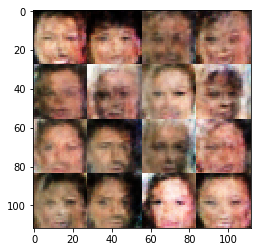

Epoch 1 of 1 	Discriminator Loss = 1.408 	Generator Loss = 0.992
Epoch 1 of 1 	Discriminator Loss = 1.460 	Generator Loss = 0.703
Epoch 1 of 1 	Discriminator Loss = 1.345 	Generator Loss = 0.940
Epoch 1 of 1 	Discriminator Loss = 1.269 	Generator Loss = 1.024
Epoch 1 of 1 	Discriminator Loss = 1.384 	Generator Loss = 0.828
Epoch 1 of 1 	Discriminator Loss = 1.323 	Generator Loss = 0.933
Epoch 1 of 1 	Discriminator Loss = 1.277 	Generator Loss = 0.883
Epoch 1 of 1 	Discriminator Loss = 1.462 	Generator Loss = 0.769
Epoch 1 of 1 	Discriminator Loss = 1.342 	Generator Loss = 0.984
Epoch 1 of 1 	Discriminator Loss = 1.388 	Generator Loss = 0.761


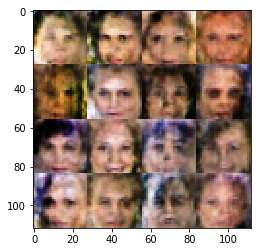

Epoch 1 of 1 	Discriminator Loss = 1.386 	Generator Loss = 0.848
Epoch 1 of 1 	Discriminator Loss = 1.283 	Generator Loss = 0.954
Epoch 1 of 1 	Discriminator Loss = 1.399 	Generator Loss = 0.795
Epoch 1 of 1 	Discriminator Loss = 1.216 	Generator Loss = 0.955
Epoch 1 of 1 	Discriminator Loss = 1.313 	Generator Loss = 0.851
Epoch 1 of 1 	Discriminator Loss = 1.286 	Generator Loss = 0.968
Epoch 1 of 1 	Discriminator Loss = 1.277 	Generator Loss = 0.884
Epoch 1 of 1 	Discriminator Loss = 1.319 	Generator Loss = 0.879
Epoch 1 of 1 	Discriminator Loss = 1.222 	Generator Loss = 0.898
Epoch 1 of 1 	Discriminator Loss = 1.309 	Generator Loss = 0.858


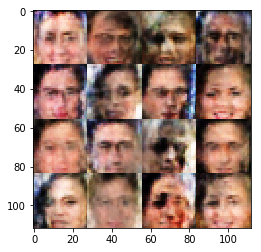

Epoch 1 of 1 	Discriminator Loss = 1.259 	Generator Loss = 0.878
Epoch 1 of 1 	Discriminator Loss = 1.162 	Generator Loss = 1.067
Epoch 1 of 1 	Discriminator Loss = 1.221 	Generator Loss = 0.922
Epoch 1 of 1 	Discriminator Loss = 1.413 	Generator Loss = 0.764
Epoch 1 of 1 	Discriminator Loss = 1.219 	Generator Loss = 0.950
Epoch 1 of 1 	Discriminator Loss = 1.297 	Generator Loss = 0.874
Epoch 1 of 1 	Discriminator Loss = 1.392 	Generator Loss = 0.920
Epoch 1 of 1 	Discriminator Loss = 1.329 	Generator Loss = 0.890
Epoch 1 of 1 	Discriminator Loss = 1.397 	Generator Loss = 0.897
Epoch 1 of 1 	Discriminator Loss = 1.359 	Generator Loss = 0.755


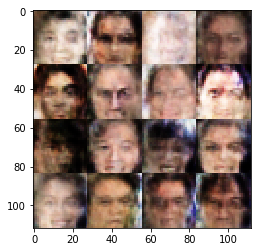

Epoch 1 of 1 	Discriminator Loss = 1.366 	Generator Loss = 0.864
Epoch 1 of 1 	Discriminator Loss = 1.211 	Generator Loss = 0.901
Epoch 1 of 1 	Discriminator Loss = 1.310 	Generator Loss = 0.995
Epoch 1 of 1 	Discriminator Loss = 1.328 	Generator Loss = 0.853
Epoch 1 of 1 	Discriminator Loss = 1.314 	Generator Loss = 0.869
Epoch 1 of 1 	Discriminator Loss = 1.351 	Generator Loss = 0.869
Epoch 1 of 1 	Discriminator Loss = 1.341 	Generator Loss = 0.847
Epoch 1 of 1 	Discriminator Loss = 1.372 	Generator Loss = 0.990
Epoch 1 of 1 	Discriminator Loss = 1.184 	Generator Loss = 1.069
Epoch 1 of 1 	Discriminator Loss = 1.289 	Generator Loss = 0.850


Epoch 1 of 1 	Discriminator Loss = 1.325 	Generator Loss = 0.865
Epoch 1 of 1 	Discriminator Loss = 1.310 	Generator Loss = 0.925
Epoch 1 of 1 	Discriminator Loss = 1.356 	Generator Loss = 0.856
Epoch 1 of 1 	Discriminator Loss = 1.351 	Generator Loss = 0.830
Epoch 1 of 1 	Discriminator Loss = 1.257 	Generator Loss = 0.831
Epoch 1 of 1 	Discriminator Loss = 1.284 	Generator Loss = 0.904
Epoch 1 of 1 	Discriminator Loss = 1.301 	Generator Loss = 0.847
Epoch 1 of 1 	Discriminator Loss = 1.295 	Generator Loss = 0.997
Epoch 1 of 1 	Discriminator Loss = 1.280 	Generator Loss = 0.886
Epoch 1 of 1 	Discriminator Loss = 1.288 	Generator Loss = 0.893


Epoch 1 of 1 	Discriminator Loss = 1.270 	Generator Loss = 0.991
Epoch 1 of 1 	Discriminator Loss = 1.502 	Generator Loss = 0.690
Epoch 1 of 1 	Discriminator Loss = 1.274 	Generator Loss = 0.761
Epoch 1 of 1 	Discriminator Loss = 1.279 	Generator Loss = 0.888
Epoch 1 of 1 	Discriminator Loss = 1.235 	Generator Loss = 0.926
Epoch 1 of 1 	Discriminator Loss = 1.354 	Generator Loss = 0.776
Epoch 1 of 1 	Discriminator Loss = 1.340 	Generator Loss = 0.909
Epoch 1 of 1 	Discriminator Loss = 1.314 	Generator Loss = 0.844
Epoch 1 of 1 	Discriminator Loss = 1.342 	Generator Loss = 0.821
Epoch 1 of 1 	Discriminator Loss = 1.258 	Generator Loss = 0.861


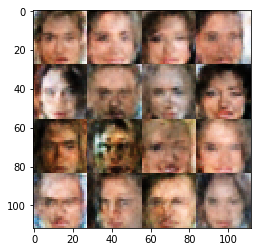

Epoch 1 of 1 	Discriminator Loss = 1.324 	Generator Loss = 0.804
Epoch 1 of 1 	Discriminator Loss = 1.223 	Generator Loss = 1.057
Epoch 1 of 1 	Discriminator Loss = 1.329 	Generator Loss = 0.889
Epoch 1 of 1 	Discriminator Loss = 1.257 	Generator Loss = 0.900
Epoch 1 of 1 	Discriminator Loss = 1.250 	Generator Loss = 0.790
Epoch 1 of 1 	Discriminator Loss = 1.221 	Generator Loss = 0.899
Epoch 1 of 1 	Discriminator Loss = 1.205 	Generator Loss = 0.919
Epoch 1 of 1 	Discriminator Loss = 1.272 	Generator Loss = 0.966
Epoch 1 of 1 	Discriminator Loss = 1.372 	Generator Loss = 0.785
Epoch 1 of 1 	Discriminator Loss = 1.433 	Generator Loss = 0.859


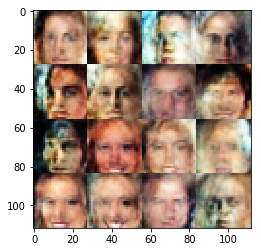

Epoch 1 of 1 	Discriminator Loss = 1.278 	Generator Loss = 0.908
Epoch 1 of 1 	Discriminator Loss = 1.282 	Generator Loss = 0.908
Epoch 1 of 1 	Discriminator Loss = 1.271 	Generator Loss = 0.803
Epoch 1 of 1 	Discriminator Loss = 1.306 	Generator Loss = 0.922
Epoch 1 of 1 	Discriminator Loss = 1.335 	Generator Loss = 0.767
Epoch 1 of 1 	Discriminator Loss = 1.243 	Generator Loss = 1.021
Epoch 1 of 1 	Discriminator Loss = 1.364 	Generator Loss = 0.830
Epoch 1 of 1 	Discriminator Loss = 1.348 	Generator Loss = 0.827
Epoch 1 of 1 	Discriminator Loss = 1.485 	Generator Loss = 0.822
Epoch 1 of 1 	Discriminator Loss = 1.383 	Generator Loss = 0.906


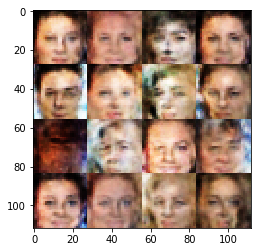

Epoch 1 of 1 	Discriminator Loss = 1.469 	Generator Loss = 0.813
Epoch 1 of 1 	Discriminator Loss = 1.254 	Generator Loss = 0.855
Epoch 1 of 1 	Discriminator Loss = 1.422 	Generator Loss = 0.859
Epoch 1 of 1 	Discriminator Loss = 1.325 	Generator Loss = 0.896
Epoch 1 of 1 	Discriminator Loss = 1.243 	Generator Loss = 0.876
Epoch 1 of 1 	Discriminator Loss = 1.437 	Generator Loss = 0.825
Epoch 1 of 1 	Discriminator Loss = 1.336 	Generator Loss = 0.803
Epoch 1 of 1 	Discriminator Loss = 1.177 	Generator Loss = 1.006
Epoch 1 of 1 	Discriminator Loss = 1.380 	Generator Loss = 0.758
Epoch 1 of 1 	Discriminator Loss = 1.359 	Generator Loss = 0.898


Epoch 1 of 1 	Discriminator Loss = 1.241 	Generator Loss = 0.977
Epoch 1 of 1 	Discriminator Loss = 1.322 	Generator Loss = 0.902
Epoch 1 of 1 	Discriminator Loss = 1.451 	Generator Loss = 0.849
Epoch 1 of 1 	Discriminator Loss = 1.381 	Generator Loss = 0.756
Epoch 1 of 1 	Discriminator Loss = 1.328 	Generator Loss = 1.060
Epoch 1 of 1 	Discriminator Loss = 1.411 	Generator Loss = 0.746
Epoch 1 of 1 	Discriminator Loss = 1.273 	Generator Loss = 0.850
Epoch 1 of 1 	Discriminator Loss = 1.267 	Generator Loss = 0.925
Epoch 1 of 1 	Discriminator Loss = 1.201 	Generator Loss = 0.948
Epoch 1 of 1 	Discriminator Loss = 1.333 	Generator Loss = 0.991


Epoch 1 of 1 	Discriminator Loss = 1.269 	Generator Loss = 0.899
Epoch 1 of 1 	Discriminator Loss = 1.349 	Generator Loss = 0.978
Epoch 1 of 1 	Discriminator Loss = 1.320 	Generator Loss = 0.825
Epoch 1 of 1 	Discriminator Loss = 1.270 	Generator Loss = 0.837
Epoch 1 of 1 	Discriminator Loss = 1.366 	Generator Loss = 0.818
Epoch 1 of 1 	Discriminator Loss = 1.294 	Generator Loss = 0.856
Epoch 1 of 1 	Discriminator Loss = 1.336 	Generator Loss = 0.752
Epoch 1 of 1 	Discriminator Loss = 1.346 	Generator Loss = 0.960
Epoch 1 of 1 	Discriminator Loss = 1.312 	Generator Loss = 0.846
Epoch 1 of 1 	Discriminator Loss = 1.302 	Generator Loss = 0.872


Epoch 1 of 1 	Discriminator Loss = 1.197 	Generator Loss = 0.948
Epoch 1 of 1 	Discriminator Loss = 1.388 	Generator Loss = 0.804
Epoch 1 of 1 	Discriminator Loss = 1.470 	Generator Loss = 0.796
Epoch 1 of 1 	Discriminator Loss = 1.278 	Generator Loss = 0.964
Epoch 1 of 1 	Discriminator Loss = 1.354 	Generator Loss = 0.764
Epoch 1 of 1 	Discriminator Loss = 1.335 	Generator Loss = 0.951
Epoch 1 of 1 	Discriminator Loss = 1.348 	Generator Loss = 0.783
Epoch 1 of 1 	Discriminator Loss = 1.207 	Generator Loss = 1.085
Epoch 1 of 1 	Discriminator Loss = 1.280 	Generator Loss = 0.968
Epoch 1 of 1 	Discriminator Loss = 1.216 	Generator Loss = 0.829


Epoch 1 of 1 	Discriminator Loss = 1.331 	Generator Loss = 0.799
Epoch 1 of 1 	Discriminator Loss = 1.323 	Generator Loss = 0.976
Epoch 1 of 1 	Discriminator Loss = 1.333 	Generator Loss = 0.829
Epoch 1 of 1 	Discriminator Loss = 1.316 	Generator Loss = 0.943
Epoch 1 of 1 	Discriminator Loss = 1.175 	Generator Loss = 0.948
Epoch 1 of 1 	Discriminator Loss = 1.362 	Generator Loss = 0.882
Epoch 1 of 1 	Discriminator Loss = 1.266 	Generator Loss = 0.886
Epoch 1 of 1 	Discriminator Loss = 1.309 	Generator Loss = 0.849
Epoch 1 of 1 	Discriminator Loss = 1.343 	Generator Loss = 0.836
Epoch 1 of 1 	Discriminator Loss = 1.173 	Generator Loss = 0.991


Epoch 1 of 1 	Discriminator Loss = 1.457 	Generator Loss = 0.746
Epoch 1 of 1 	Discriminator Loss = 1.354 	Generator Loss = 0.770
Epoch 1 of 1 	Discriminator Loss = 1.241 	Generator Loss = 1.038
Epoch 1 of 1 	Discriminator Loss = 1.427 	Generator Loss = 0.789
Epoch 1 of 1 	Discriminator Loss = 1.362 	Generator Loss = 0.671
Epoch 1 of 1 	Discriminator Loss = 1.339 	Generator Loss = 0.782
Epoch 1 of 1 	Discriminator Loss = 1.332 	Generator Loss = 0.891
Epoch 1 of 1 	Discriminator Loss = 1.309 	Generator Loss = 0.750
Epoch 1 of 1 	Discriminator Loss = 1.314 	Generator Loss = 0.778
Epoch 1 of 1 	Discriminator Loss = 1.358 	Generator Loss = 1.046


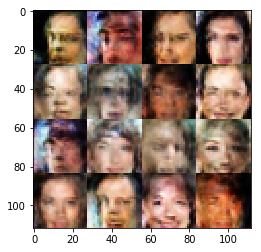

Epoch 1 of 1 	Discriminator Loss = 1.314 	Generator Loss = 0.814
Epoch 1 of 1 	Discriminator Loss = 1.434 	Generator Loss = 0.752
Epoch 1 of 1 	Discriminator Loss = 1.231 	Generator Loss = 0.894
Epoch 1 of 1 	Discriminator Loss = 1.208 	Generator Loss = 0.905
Epoch 1 of 1 	Discriminator Loss = 1.301 	Generator Loss = 0.829
Epoch 1 of 1 	Discriminator Loss = 1.189 	Generator Loss = 1.059
Epoch 1 of 1 	Discriminator Loss = 1.263 	Generator Loss = 0.832
Epoch 1 of 1 	Discriminator Loss = 1.386 	Generator Loss = 0.740
Epoch 1 of 1 	Discriminator Loss = 1.193 	Generator Loss = 0.892
Epoch 1 of 1 	Discriminator Loss = 1.444 	Generator Loss = 0.700


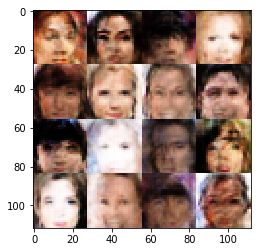

Epoch 1 of 1 	Discriminator Loss = 1.341 	Generator Loss = 0.849
Epoch 1 of 1 	Discriminator Loss = 1.206 	Generator Loss = 0.912
Epoch 1 of 1 	Discriminator Loss = 1.327 	Generator Loss = 0.869
Epoch 1 of 1 	Discriminator Loss = 1.287 	Generator Loss = 0.897
Epoch 1 of 1 	Discriminator Loss = 1.345 	Generator Loss = 0.860
Epoch 1 of 1 	Discriminator Loss = 1.411 	Generator Loss = 0.768


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.